# X-Ray Computed Tomography: Incomplete Data

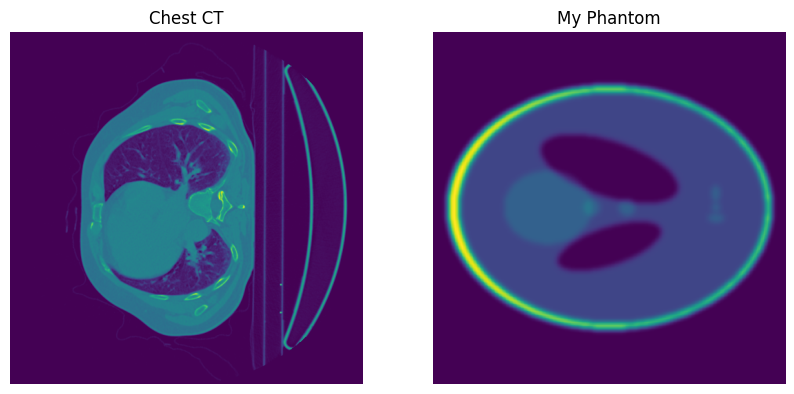

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Load the datasets using h5py
with h5py.File('data/chestCT.mat', 'r') as f_chest:
    chest_data = np.array(f_chest['imageAC'])
with h5py.File('data/myPhantom.mat', 'r') as f_phantom:
    phantom_data = np.array(f_phantom['imageMyPhantomAC'])

datasets = {'chestCT': chest_data, 'myPhantom': phantom_data}

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(datasets['chestCT'])
plt.title('Chest CT')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(datasets['myPhantom'])
plt.title('My Phantom')
plt.axis('off')

plt.show()

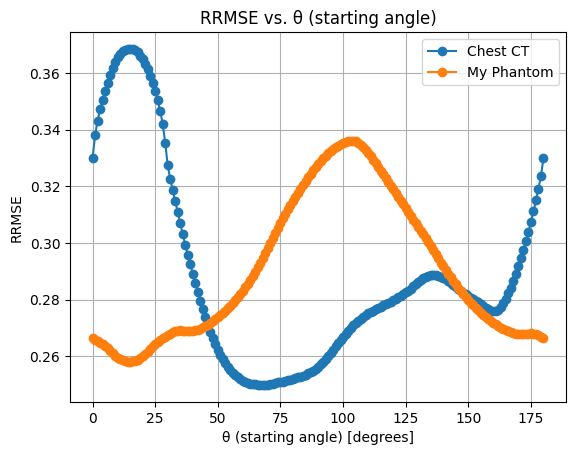

In [2]:
from skimage.transform import radon, iradon
from joblib import Parallel, delayed


# Compute RRMSE
def rrmse(a, b):
    return np.sqrt(np.sum((a - b) ** 2)) / np.sqrt(np.sum(a ** 2))


# Define parameters
total_angles = 180
projection_span = 150  # Data spans 150 degrees


# Function to compute RRMSE for a given theta
def compute_recon_rrmse(ground_truth, theta):
    angles = np.arange(theta, theta + projection_span + 1) % 180  # Wrap around at 180
    sinogram = radon(ground_truth, theta=angles, circle=False)
    reconstructed = iradon(sinogram, theta=angles, circle=False)
    return rrmse(reconstructed, ground_truth)


# Parallel computation of RRMSE for each theta
rrmse_values_chestCT = Parallel(n_jobs=-1)(
    delayed(compute_recon_rrmse)(datasets['chestCT'], theta) for theta in range(total_angles + 1))
rrmse_values_myPhantom = Parallel(n_jobs=-1)(
    delayed(compute_recon_rrmse)(datasets['myPhantom'], theta) for theta in range(total_angles + 1))

plt.plot(range(total_angles + 1), rrmse_values_chestCT, marker='o', linestyle='-', label="Chest CT")
plt.plot(range(total_angles + 1), rrmse_values_myPhantom, marker='o', linestyle='-', label="My Phantom")
plt.xlabel("θ (starting angle) [degrees]")
plt.ylabel("RRMSE")
plt.title("RRMSE vs. θ (starting angle)")
plt.legend()
plt.grid(True)
plt.show()

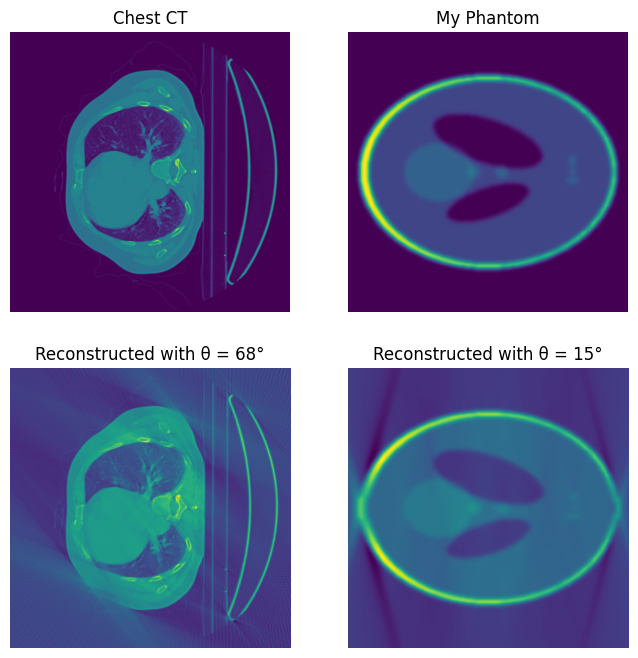

In [3]:
min_theta_chestCT = np.argmin(rrmse_values_chestCT)
min_theta_myPhantom = np.argmin(rrmse_values_myPhantom)

angles_chestCT = np.arange(min_theta_chestCT, min_theta_chestCT + projection_span + 1) % 180
sinogram_chestCT = radon(datasets['chestCT'], theta=angles_chestCT, circle=False)
recon_chestCT = iradon(sinogram_chestCT, theta=angles_chestCT, circle=False)

angles_myPhantom = np.arange(min_theta_myPhantom, min_theta_myPhantom + projection_span + 1) % 180
sinogram_myPhantom = radon(datasets['myPhantom'], theta=angles_myPhantom, circle=False)
recon_myPhantom = iradon(sinogram_myPhantom, theta=angles_myPhantom, circle=False)

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(datasets['chestCT'])
plt.title('Chest CT')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(datasets['myPhantom'])
plt.title('My Phantom')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(recon_chestCT)
plt.title(f'Reconstructed with θ = {min_theta_chestCT}°')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(recon_myPhantom)
plt.title(f'Reconstructed with θ = {min_theta_myPhantom}°')
plt.axis('off')

plt.show()